In [1]:
import numpy as np
import torch
import torchvision
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
print(torch.__version__)

1.0.0


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [749]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(64)
        
    
    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x), 0.2)
        x2 = F.leaky_relu(self.bn1(self.conv2(x1)), 0.2)
        x3 = F.leaky_relu(self.bn2(self.conv3(x2)), 0.2)
        x4 = F.leaky_relu(self.bn3(self.conv4(x3)), 0.2)
        x5 = F.leaky_relu(self.bn4(self.conv5(x4)), 0.2)
        x6 = F.leaky_relu(self.bn5(self.conv6(x5)), 0.2)
        return (x1, x2, x3, x4, x5, x6)
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [762]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(96, 32, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
    
    def forward(self, x):
        x1, x2, x3, x4, x5, x6 = x
        x5d = F.relu(F.dropout(self.bn1(self.conv1(x6))))
        x5 = torch.cat([x5d, x5], dim = 1)
        x4d = F.relu(F.dropout(self.bn2(self.conv2(x5))))
        x4 = torch.cat([x4d, x4], dim = 1)
        x3d = F.relu(F.dropout(self.bn3(self.conv3(x4))))
        x3 = torch.cat([x3d, x3], dim = 1)
        x2d = F.relu(F.dropout(self.bn4(self.conv4(x3))))
        x2 = torch.cat([x2d, x2], dim = 1)
        x1d = F.relu(F.dropout(self.bn5(self.conv5(x2))))
        x1 = torch.cat([x1d, x1], dim = 1)
        x = torch.tanh(self.conv6(x1))
        return x
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [763]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        self.enc.init(0, 0.02)
        self.dec.init(0, 0.02)
        
    def forward(self, x):
        h = self.enc(x)
        yh = self.dec(h)
        return yh
        

In [764]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn1(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
#         x = torch.mean(x)
        return x
    
    def init(self, mean, std):
        for param in self.parameters():
            torch.nn.init.normal_(param, mean, std)

In [765]:
train_dir = 'D:/facades/facades/train/'
val_dir = 'D:/facades/facades/val/'
test_dir = 'D:/facades/facades/test/'

In [766]:
class FacadesDataset(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_ids = os.listdir(self.root_dir) 
            
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, idx):
        sample_id = self.file_ids[idx]
        img = Image.open(os.path.join(self.root_dir, sample_id))
        label = img.crop((0, 0, 256, 256))
        data = img.crop((256, 0, 512, 256))
        if self.transform:
            data = self.transform(data)
            label = self.transform(label)
        return data, label

In [767]:
m = 0.5
s = 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = (m, m, m), std = (s, s, s))])

In [768]:
train_dataset = FacadesDataset(train_dir, transform)

In [769]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=0,
                                     pin_memory=False)

In [770]:
G = Generator()
G.to(device)

Generator(
  (enc): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dec): Decoder(
    (conv1): ConvTran

In [771]:
D = Discriminator()
D.init(0, 0.02)
D.to(device)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

In [772]:
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5, 0.999)) 
G_optimizer = optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5, 0.999)) 

In [773]:
BCE = nn.BCELoss()
L1 = nn.L1Loss()
train_loss = []
n_epochs = 15

for e in range(n_epochs):
    for i in range(len(train_loader)):
        data, label = next(iter(train_loader))
        data = data.to(device)
        label = label.to(device)
            
        Gx = G(data)
        fake_data = torch.cat([Gx, data], dim = 1)
        real_data = torch.cat([label, data], dim = 1)

        y_fake = D(fake_data)
        y_real = D(real_data)

        D_loss = 0.5*(BCE(y_real, torch.ones_like(y_real).to(device)) + \
                      BCE(y_fake, torch.zeros_like(y_fake).to(device)))

        D_optimizer.zero_grad()
        D_loss.backward() 
        D_optimizer.step()
        
        Gx = G(data)
        fake_data = torch.cat([Gx, data], dim = 1)
        y_fake = D(fake_data)

        G_loss = (BCE(y_fake, torch.ones_like(y_fake).to(device)) + 20*L1(Gx, label))

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        train_loss.append((G_loss.item(), D_loss.item()))
        
        if i % 50 == 0:
            print('epoch = {}, iter = {}, loss = {:.4f}, {:.4f}'.format(e, i, train_loss[-1][0],
                                                                   train_loss[-1][1]))        

epoch = 0, iter = 0, loss = 9.1514, 0.6931
epoch = 0, iter = 50, loss = 6.0002, 0.6395
epoch = 0, iter = 100, loss = 6.7889, 0.4994
epoch = 0, iter = 150, loss = 8.1462, 0.3764
epoch = 0, iter = 200, loss = 8.0245, 0.2660
epoch = 0, iter = 250, loss = 10.3408, 0.2096
epoch = 0, iter = 300, loss = 13.9641, 0.1701
epoch = 0, iter = 350, loss = 10.1477, 0.1626
epoch = 1, iter = 0, loss = 8.6187, 0.4311
epoch = 1, iter = 50, loss = 10.0338, 0.1914
epoch = 1, iter = 100, loss = 7.4651, 0.2635
epoch = 1, iter = 150, loss = 12.1233, 0.0892
epoch = 1, iter = 200, loss = 9.2936, 0.2447
epoch = 1, iter = 250, loss = 8.7021, 0.7032
epoch = 1, iter = 300, loss = 8.5451, 0.5080
epoch = 1, iter = 350, loss = 6.8930, 0.5574
epoch = 2, iter = 0, loss = 10.0021, 0.2467
epoch = 2, iter = 50, loss = 7.8502, 0.5986
epoch = 2, iter = 100, loss = 9.5136, 0.5992
epoch = 2, iter = 150, loss = 9.4738, 0.5890
epoch = 2, iter = 200, loss = 8.5734, 0.5752
epoch = 2, iter = 250, loss = 10.5807, 0.3312
epoch = 2, i

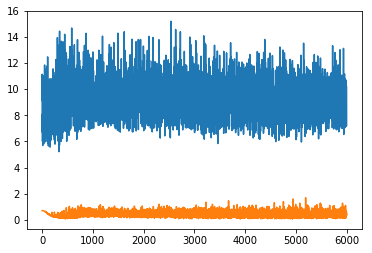

In [774]:
plt.plot(train_loss)

In [775]:
val_dataset = FacadesDataset(val_dir, transform)

In [776]:
batch_size = 5
val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=0,
                                     pin_memory=False)

In [777]:
data, label = next(iter(val_loader))
data = data.to(device)
label = label.to(device)

In [778]:
Gx = G(data)
Gx = Gx.detach().cpu().numpy()
Gx = np.transpose(Gx, (2, 3, 1, 0))
Gx = Gx*s*np.ones_like(Gx)
Gx = Gx + m*np.ones_like(Gx)

label = label.detach().cpu().numpy()
label = np.transpose(label, (2, 3, 1, 0))
label = label*s*np.ones_like(label)
label = label + m*np.ones_like(label)

data = data.detach().cpu().numpy()
data = np.transpose(data, (2, 3, 1, 0))
data = data*s*np.ones_like(data)
data = data + m*np.ones_like(data)

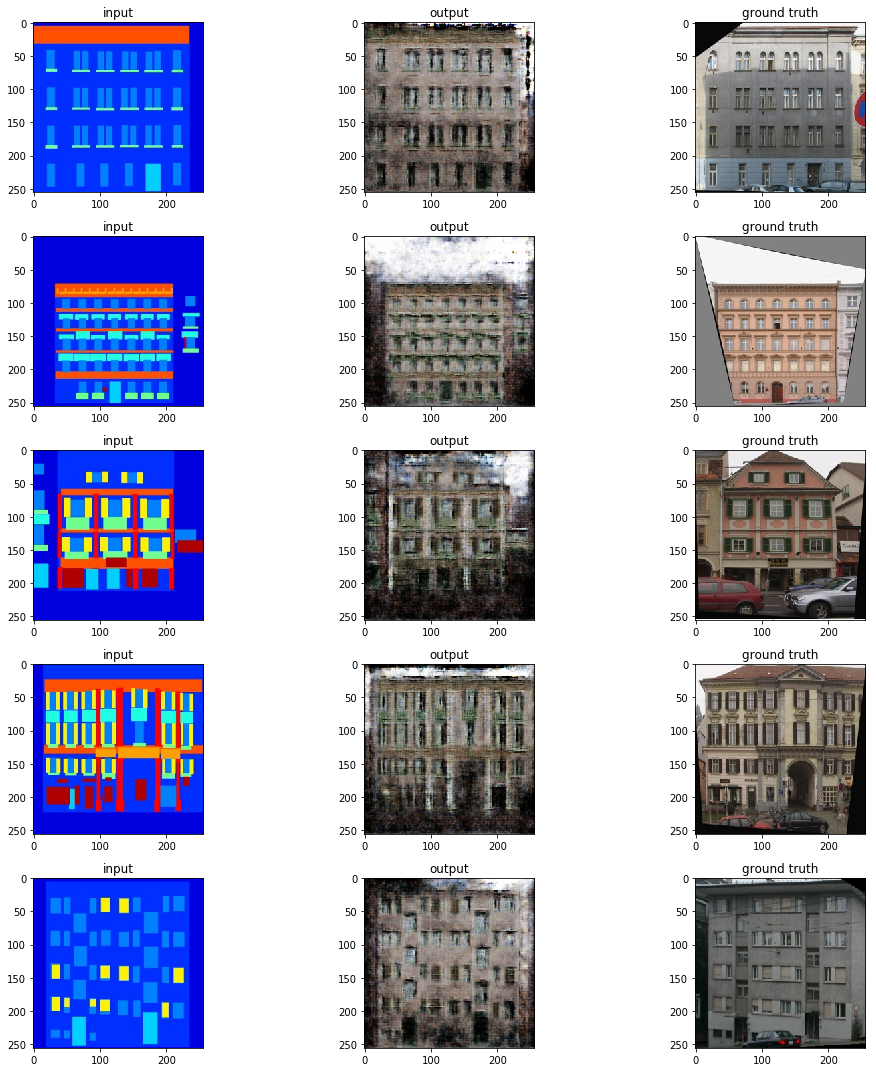

In [780]:
fig = plt.figure(figsize = (15, 15))
c = 3
for i in range(batch_size):
    fig.add_subplot(batch_size, c, i*c + 1)
    plt.imshow(data[:, :, :, i])
    plt.title('input')
    fig.add_subplot(batch_size, c, i*c + 2)
    plt.imshow(Gx[:, :, :, i])
    plt.title('output')
    fig.add_subplot(batch_size, c, i*c + 3)
    plt.imshow(label[:, :, :, i])
    plt.title('ground truth')
fig.tight_layout()